# Build a regression model.

NOTE:

While we have two dataframes, both Foursquare and YELP, the Foursquare one is almost 3 times larger with 717 rows of data and will be therefore used in a regression. More data the better.

As stated previously, the YELP api is rate limited to 500 calls and we couldn't get all 717 bike stations into the api. As such we only have 250 observations.

Given this, going forward for the model, we will be using the Foursquare dataframe.



In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv('fsq_BarLibs_BikeRadius.csv')
df

# We will need to drop the 'Unnamed: 0' column at some point as its a duplicate of 'bike_station#'

,Unnamed: 0,bike_station#,latitude,longitude,free_bikes,num_of_bars,min_bar_dist,num_of_libs,min_libs_dist
0,0,0,43.665269,-79.319796,18,11,608.0,2,810.0
1,1,1,43.671420,-79.445947,2,19,292.0,1,664.0
2,2,2,43.666224,-79.317693,10,8,413.0,2,766.0
3,3,3,43.653236,-79.376716,4,50,122.0,9,302.0
4,4,4,43.663722,-79.380288,23,46,43.0,6,555.0
...,...,...,...,...,...,...,...,...,...
712,712,712,43.601915,-79.499419,1,0,NaN,1,885.0
713,713,713,43.642852,-79.531995,1,8,159.0,0,NaN
714,714,714,43.650945,-79.379498,0,50,139.0,0,NaN
715,715,715,43.707356,-79.437231,0,0,NaN,0,NaN


In [7]:
df.info()

# we have a chunk of NaN's in 'min_bar_dist' and 'min_libs_dist' - this has to do with how some bars/libs in the 
# API query/json didnt have a distance value. We implemented a Try/Except to error handle this
# and replaced them with NaN's

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     717 non-null    int64  
 1   bike_station#  717 non-null    int64  
 2   latitude       717 non-null    float64
 3   longitude      717 non-null    float64
 4   free_bikes     717 non-null    int64  
 5   num_of_bars    717 non-null    int64  
 6   min_bar_dist   629 non-null    float64
 7   num_of_libs    717 non-null    int64  
 8   min_libs_dist  586 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 50.5 KB


Provide model output and an interpretation of the results. 

In [5]:
df.describe()
#

,Unnamed: 0,bike_station#,latitude,longitude,free_bikes,num_of_bars,min_bar_dist,num_of_libs,min_libs_dist
count,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,629.000000,717.000000,586.000000
mean,358.000000,358.000000,43.668192,-79.391842,7.966527,22.909344,302.914149,4.016736,463.341297
std,207.124359,207.124359,0.031210,0.061901,6.272356,19.379088,1138.491351,4.694255,263.245600
min,0.000000,0.000000,43.588077,-79.544491,0.000000,0.000000,5.000000,0.000000,2.000000
25%,179.000000,179.000000,43.648657,-79.426680,3.000000,3.000000,84.000000,1.000000,247.000000
50%,358.000000,358.000000,43.661791,-79.393249,7.000000,19.000000,178.000000,2.000000,434.000000
75%,537.000000,537.000000,43.680877,-79.365364,12.000000,44.000000,376.000000,5.000000,667.750000
max,716.000000,716.000000,43.788319,-79.123505,32.000000,50.000000,28252.000000,24.000000,1356.000000


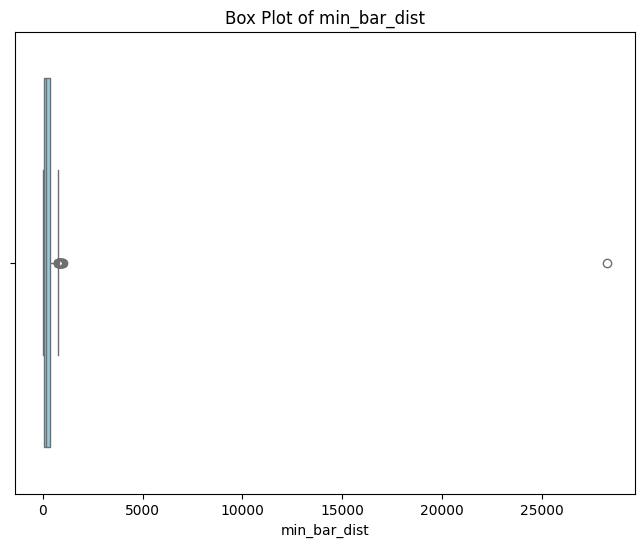

In [46]:
# a really weird outlier for 'min_bar_dist' not sure why there is a min bar dist of 28,252m, lets look at a scatter plot.
plt.figure(figsize=(8, 6))
sns.boxplot(x=df__cleaned['min_bar_dist'], color='skyblue')
plt.title('Box Plot of min_bar_dist')
plt.xlabel('min_bar_dist')
plt.show()

# ok wow huge single outlier, were gonna have to drop that row...

In [47]:
# We will remove the first column and some rows containing NaN's so we should expect a smaller DataFrame.
df.shape

(717, 9)

## Data Quality Check

Checking for and dealing with NULL/Missing/Unnecessary Columns

In [48]:
# we can see the percentage of missing values across each column

round(100 * (df.isnull().sum()/len(df)), 2).sort_values(ascending=False)

# As we expected with the NaN's in both POI distance columns - some POI's didnt have distance values.

min_libs_dist    18.27
min_bar_dist     12.27
Unnamed: 0        0.00
bike_station#     0.00
latitude          0.00
longitude         0.00
free_bikes        0.00
num_of_bars       0.00
num_of_libs       0.00
dtype: float64

In [49]:
# We can also do the above by row

round(100 * (df.isnull().sum(axis=1)/len(df)), 2).sort_values(ascending=False)

# we can see a chunk of rows have missing data and those are most definetly coming from the two POI distance columns

556    0.28
197    0.28
578    0.28
459    0.28
303    0.28
       ... 
261    0.00
262    0.00
263    0.00
264    0.00
716    0.00
Length: 717, dtype: float64

## Scouting for Duplicates

Given that every single bike station lat/long values are unique, we shouldnt expect to see any.

In [50]:
df_dupe = df.copy()
df_dupe.drop_duplicates(subset=None, inplace=True)

In [51]:
print(f'Shape of df is: {df.shape}')
print(f'\nShape of df_dupe is: {df_dupe.shape}')

# Success, no duplicates! No difference between the two DataFrames, we can go ahead and delete df_dupe

Shape of df is: (717, 9)

Shape of df_dupe is: (717, 9)


In [52]:
del df_dupe

## Cleaning the DataFrame

Based on the above, we're going to:

- Remove the first column as it is an identical to 'bike_station#'

- Remove the rows containing NaN values - they are coming from the POI distance columns. While you could impute new values or regress new ones, we didn't feel that it would be wise to do that.
if no data on distance exists, it would be wrong to impute some sort of value or apply the mean of all values and we definetly didn't want to replace them with 0's.

In [53]:
# Removing the first column

df_1 = df.drop('Unnamed: 0', axis=1)
df_1

,bike_station#,latitude,longitude,free_bikes,num_of_bars,min_bar_dist,num_of_libs,min_libs_dist
0,0,43.665269,-79.319796,18,11,608.0,2,810.0
1,1,43.671420,-79.445947,2,19,292.0,1,664.0
2,2,43.666224,-79.317693,10,8,413.0,2,766.0
3,3,43.653236,-79.376716,4,50,122.0,9,302.0
4,4,43.663722,-79.380288,23,46,43.0,6,555.0
...,...,...,...,...,...,...,...,...
712,712,43.601915,-79.499419,1,0,NaN,1,885.0
713,713,43.642852,-79.531995,1,8,159.0,0,NaN
714,714,43.650945,-79.379498,0,50,139.0,0,NaN
715,715,43.707356,-79.437231,0,0,NaN,0,NaN


In [54]:
# Removing all rows with NaN values

df__cleaned = df_1.dropna().reset_index(drop=True)
df__cleaned

# We can see our dataframe has shrunk a fair amount, we now have 526 rows versus the original 717. Nonetheless, it is still more than double that of the YELP dataframe (250 rows).

,bike_station#,latitude,longitude,free_bikes,num_of_bars,min_bar_dist,num_of_libs,min_libs_dist
0,0,43.665269,-79.319796,18,11,608.0,2,810.0
1,1,43.671420,-79.445947,2,19,292.0,1,664.0
2,2,43.666224,-79.317693,10,8,413.0,2,766.0
3,3,43.653236,-79.376716,4,50,122.0,9,302.0
4,4,43.663722,-79.380288,23,46,43.0,6,555.0
...,...,...,...,...,...,...,...,...
521,706,43.620526,-79.483202,12,2,802.0,1,272.0
522,707,43.598419,-79.515611,1,2,467.0,1,477.0
523,709,43.645659,-79.523399,7,10,88.0,1,764.0
524,710,43.594458,-79.533874,0,5,91.0,1,205.0


In [56]:
# Removing the min_bar_dist outlier...

df__cleaned2 = df__cleaned[df__cleaned['min_bar_dist'] != 28252]
df__cleaned2.describe()

# Nice looks better now.

,bike_station#,latitude,longitude,free_bikes,num_of_bars,min_bar_dist,num_of_libs,min_libs_dist
count,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000
mean,342.662857,43.665470,-79.392378,8.074286,27.803810,240.769524,5.015238,448.594286
std,206.703430,0.026588,0.054167,6.419214,18.198901,210.345468,4.793021,254.146576
min,0.000000,43.592742,-79.540330,0.000000,1.000000,6.000000,1.000000,14.000000
25%,165.000000,43.648711,-79.422968,2.000000,9.000000,78.000000,2.000000,238.000000
50%,334.000000,43.660274,-79.392480,7.000000,27.000000,168.000000,3.000000,424.000000
75%,522.000000,43.676216,-79.368730,12.000000,48.000000,355.000000,7.000000,636.000000
max,716.000000,43.776490,-79.185218,32.000000,50.000000,983.000000,24.000000,997.000000


In [57]:
df__cleaned2.info()

# Great, we're clean! all columsn have 525 values and non of them are NULL/NaN

<class 'pandas.core.frame.DataFrame'>
Index: 525 entries, 0 to 525
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bike_station#  525 non-null    int64  
 1   latitude       525 non-null    float64
 2   longitude      525 non-null    float64
 3   free_bikes     525 non-null    int64  
 4   num_of_bars    525 non-null    int64  
 5   min_bar_dist   525 non-null    float64
 6   num_of_libs    525 non-null    int64  
 7   min_libs_dist  525 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 36.9 KB


In [58]:
# Lets do a histogram to understand the distribution of every single column

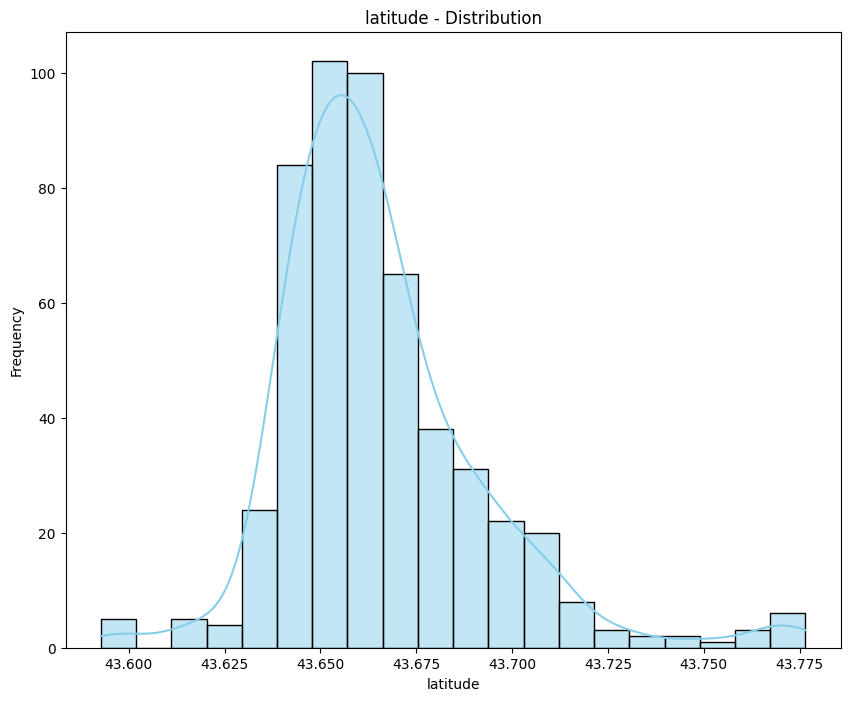

In [59]:
column = 'latitude'

plt.figure(figsize=(10, 8))
sns.histplot(df__cleaned2[column], kde=True, bins=20, color='skyblue')
plt.title(f'{column} - Distribution')
plt.xlabel(column)
plt.ylabel('Frequency')
plt.show()

# Fairly normally distributed with a slight right skew

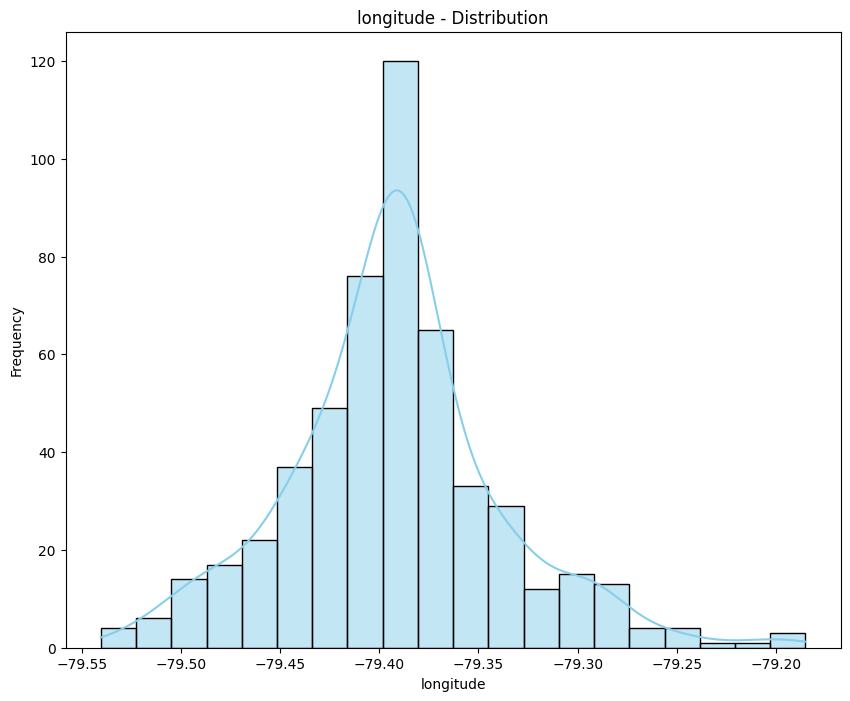

In [60]:
column = 'longitude'

plt.figure(figsize=(10, 8))
sns.histplot(df__cleaned2[column], kde=True, bins=20, color='skyblue')
plt.title(f'{column} - Distribution')
plt.xlabel(column)
plt.ylabel('Frequency')
plt.show()

# Appears normally distributed

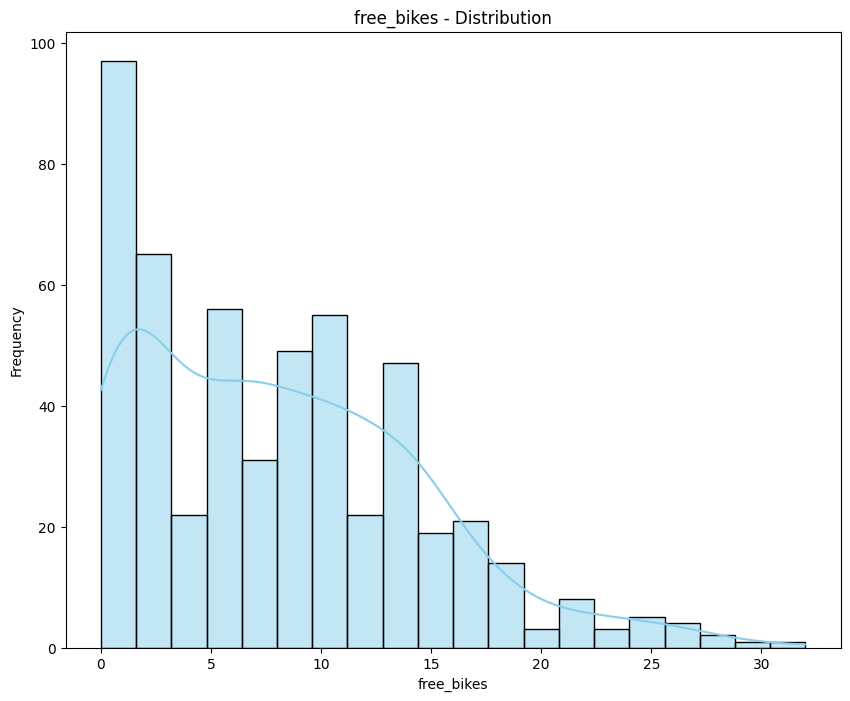

In [61]:
column = 'free_bikes'

plt.figure(figsize=(10, 8))
sns.histplot(df__cleaned2[column], kde=True, bins=20, color='skyblue')
plt.title(f'{column} - Distribution')
plt.xlabel(column)
plt.ylabel('Frequency')
plt.show()

# Appears skewed to the right - might be as a result of the time of day that the query was ran (late afternoon/early evening), maybe less bikes available and are in-use...

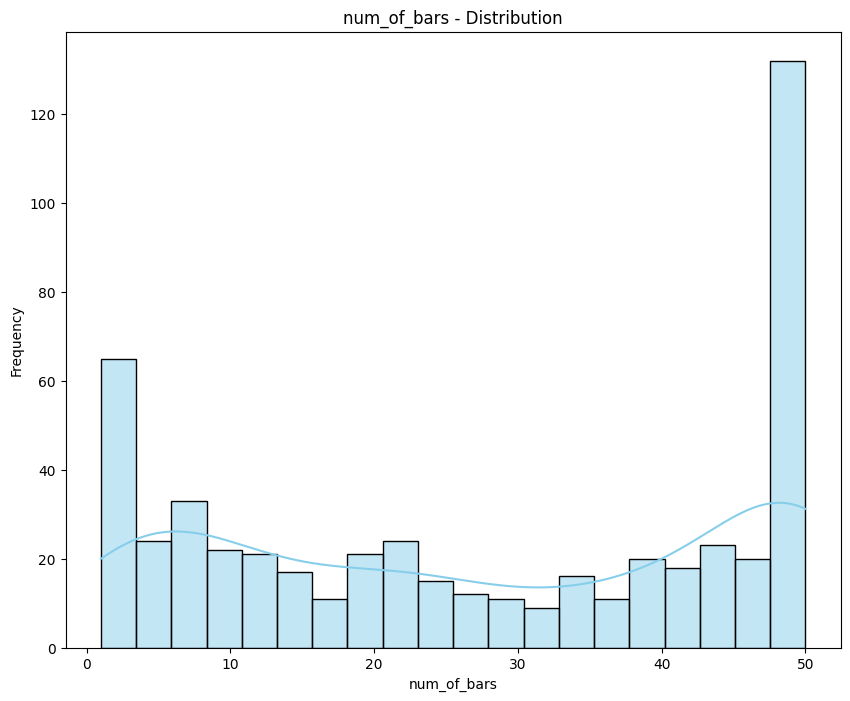

In [62]:
column = 'num_of_bars'

plt.figure(figsize=(10, 8))
sns.histplot(df__cleaned2[column], kde=True, bins=20, color='skyblue')
plt.title(f'{column} - Distribution')
plt.xlabel(column)
plt.ylabel('Frequency')
plt.show()

# quite an odd distribution - in our API request, we set the limit to 50, as that is the maximum allowd, so potentially the high frequency of 50 values is indicative 
# of there being more than 50 bars in radius of bike stations

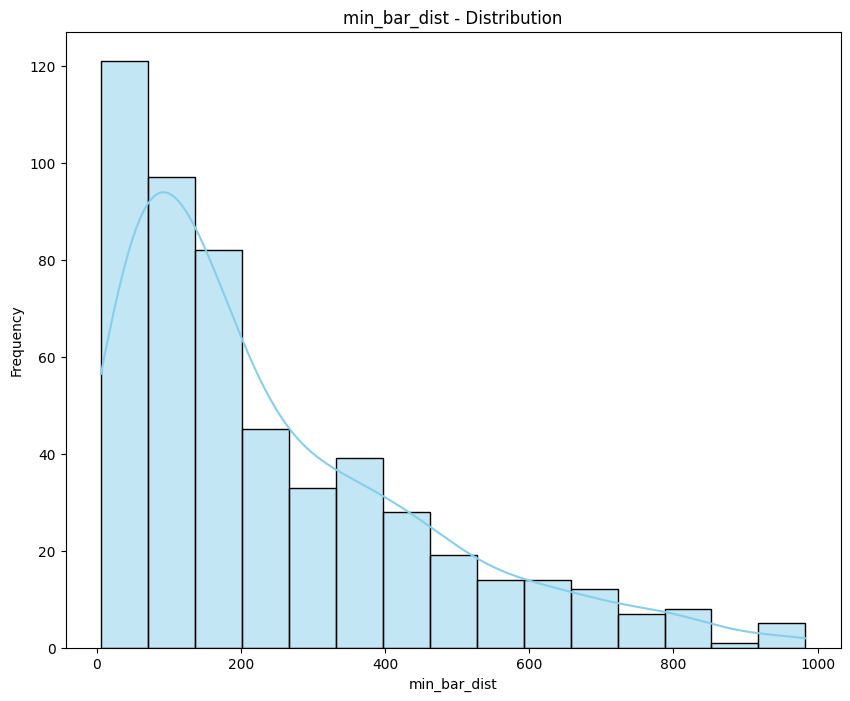

In [63]:
column = 'min_bar_dist'

plt.figure(figsize=(10, 8))
sns.histplot(df__cleaned2[column], kde=True, bins='auto', color='skyblue')
plt.title(f'{column} - Distribution')
plt.xlabel(column)
plt.ylabel('Frequency')
plt.show()

# A right skew with majority of bars with the closest distance to bike station sitting between 0 and 200 meters. interesting.

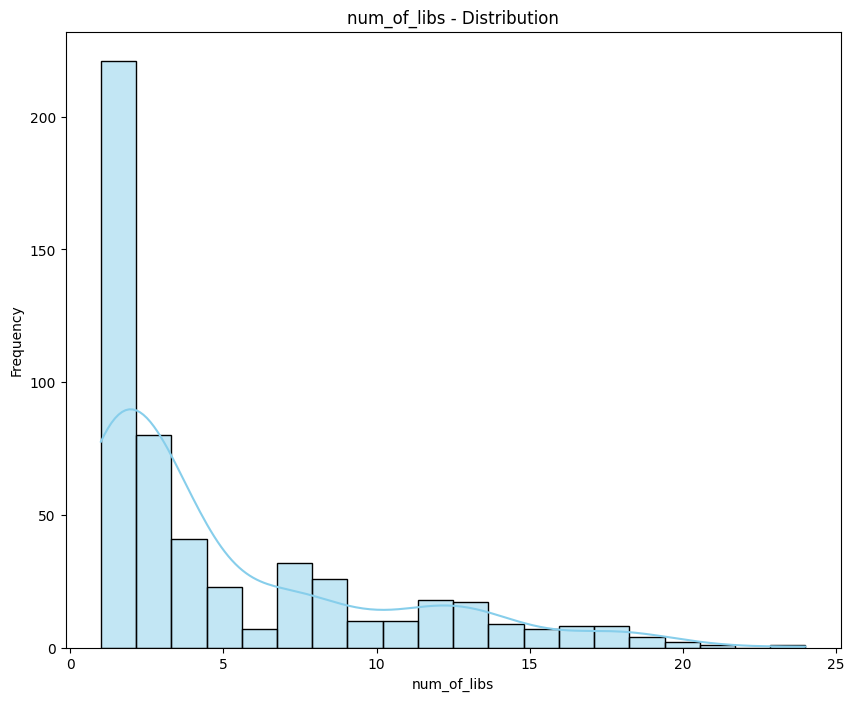

In [64]:
column = 'num_of_libs'

plt.figure(figsize=(10, 8))
sns.histplot(df__cleaned2[column], kde=True, bins=20, color='skyblue')
plt.title(f'{column} - Distribution')
plt.xlabel(column)
plt.ylabel('Frequency')
plt.show()

# A strong right-skewed, heavy-tailed distribution - this tells us that there really arent too many libraries around, definetly not as many as there are bars. This is as expected.

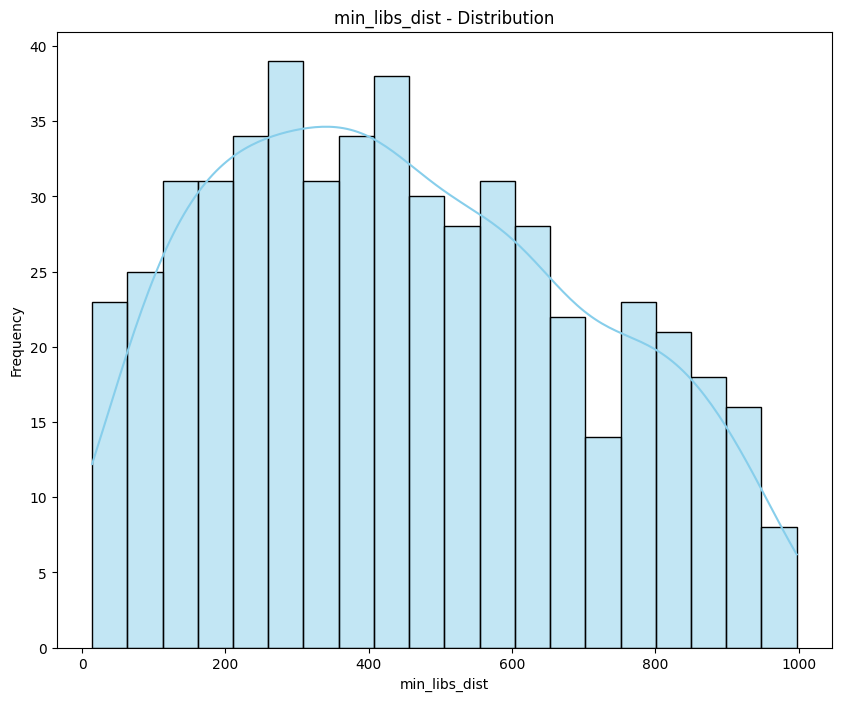

In [65]:
column = 'min_libs_dist'

plt.figure(figsize=(10, 8))
sns.histplot(df__cleaned2[column], kde=True, bins=20, color='skyblue')
plt.title(f'{column} - Distribution')
plt.xlabel(column)
plt.ylabel('Frequency')
plt.show()

# so unlike bars, with being relatively close to bike stations, libraries tend to be situated generally farther away with distances being between 200 and 600m from bike stations. Bars for the win.

## Correlation Matrix

Before we run our regression, lets get an idea of variables' correlation with each other and create a correlation matrix

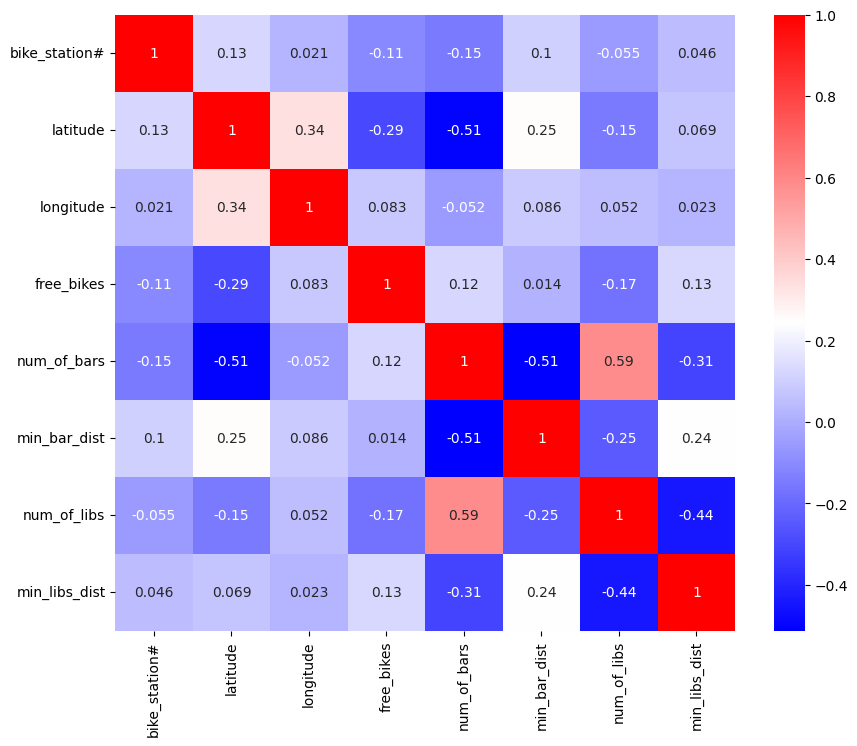

In [66]:
plt.figure(figsize=(10,8))
sns.heatmap(df__cleaned2.corr(), annot = True, cmap='bwr')
plt.show()

## Building the Model

For this we'll be predicting the number of free bikes and our regressors will be:

- number of bars ('num_of_bars')
- bar with the closest distance ('min_bar_dist')
- number of library's ('num_of_libs')
- library with the closest distance ('min_libs_dist')

Given that were trying to predict a numerical or continous variable (free_bikes) we'll be performing an Ordinary Least Square (OLS) regression, with
a Least Squares method.

In [67]:
# our dataframe
df__cleaned2

,bike_station#,latitude,longitude,free_bikes,num_of_bars,min_bar_dist,num_of_libs,min_libs_dist
0,0,43.665269,-79.319796,18,11,608.0,2,810.0
1,1,43.671420,-79.445947,2,19,292.0,1,664.0
2,2,43.666224,-79.317693,10,8,413.0,2,766.0
3,3,43.653236,-79.376716,4,50,122.0,9,302.0
4,4,43.663722,-79.380288,23,46,43.0,6,555.0
...,...,...,...,...,...,...,...,...
521,706,43.620526,-79.483202,12,2,802.0,1,272.0
522,707,43.598419,-79.515611,1,2,467.0,1,477.0
523,709,43.645659,-79.523399,7,10,88.0,1,764.0
524,710,43.594458,-79.533874,0,5,91.0,1,205.0


## Hypothesis Test:

Before we evaluate our model we should set up a hypothesis test, and so our is:

Null Hypothesis (H0):

            None of the 4 regressors will prove significant and have no sizeable/significant effect on the regressand, availability of bikes.
    
Alternative Hypothesis (HA):

            Atleast one of the 4 regressors will prove to have a significant effect (relationship) with the regressand, availability of bikes.


In [93]:
# Our regressors - characteristics of POI's (bars and libraries)
x = df__cleaned2[['num_of_bars', 'min_bar_dist', 'num_of_libs', 'min_libs_dist']]

# Our regressand - we're trying to predict the number of free bikes
Y = df__cleaned2['free_bikes']


Our model/equation:

\begin{align*}
  Y = \beta_0 + \beta_1 \cdot \text{num\_of\_bars} + \beta_2 \cdot \text{min\_bar\_dist} + \beta_3 \cdot \text{num\_of\_libs} + \beta_4 \cdot \text{min\_libs\_dist} + \varepsilon \
\end{align*}

In [94]:
# Adding a constant to the regressors

x = sm.add_constant(x)

In [95]:
# Fitting our model

model = sm.OLS(Y, x)

In [96]:
# Lets see the results:

results = model.fit()
summary = results.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             free_bikes   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     18.18
Date:                Sun, 22 Oct 2023   Prob (F-statistic):           5.43e-14
Time:                        19:16:57   Log-Likelihood:                -1686.2
No. Observations:                 525   AIC:                             3382.
Df Residuals:                     520   BIC:                             3404.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.7293      0.971      4.868      0.000       2.821       6.638
num_of_bars       0.1465      0.020      7.232      0.000       0.107       0.186
min_bar_dist      0.0037      0.001      2.529      0.012       0.001       0.007
num_of_libs      -0.4774      0.073     -6.570      0.000      -0.620      -0.335
min_libs_dist     0.0017      0.001      1.459      0.145      -0.001       0.004
==============================================================================
Omnibus:                       37.092   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.090
Skew:                           0.690   Prob(JB):                     4.40e-10
Kurtosis:                       3.253   Cond. No.                     2.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Interpreting the Results

- Adjusted R-squared: Given that we have more than one regressor, we consider the Adj R-squared and with a value of 0.116, this means that indpendant variables
in the model explain 11.6% of the variablility in the number of free bikes
- F-statistic along with its p-value: Having values of 18.18 and 5.43e-14, this tells us that atleast one independent variable is significantly related to the regressand
- The coef or coefficients, taking on values like:

\begin{align*}
  Y = 4.7293 + 0.1465 \cdot \text{num\_of\_bars} + 0.0037 \cdot \text{min\_bar\_dist} - 0.4774 \cdot \text{num\_of\_libs} + 0.0017 \cdot \text{min\_libs\_dist} + \varepsilon
\end{align*}

For every unit increase in the number of bars, the number of free bikes goes up by 14.65% and for every unit increase number of librarys, the number of bikes goes down by 47.74%.
These make sense, if people are cycling to stations near bars, there would be a higher availbility of bikes at those stations and vice versa for librarys - given that this api call to city bikes
was made in the evening, you would expect there to be a low availability of bikes available at librarys as people are taking them to go home.

- P-values: the num_of_bars and min_bar_dist are significant at 10 and 5% and 1% while min_libs_dist is only significant at 10 and 5%.

- low P-values for omnibus and jarque-bera test would tell us that our residuals are not normally distributed. Meaning potential biased predictions, incorrect conclusions etc..

Given that 'min_libs_dist' is not significant, even at 10%, we tried taking it out but it worsens the models adj r-squared, so we left it in. While it is unsignificant, it has some,
although little explainability.

In the end, the model could do with some more variables, hence the low adj r-squared.

As for our hypothesis test, well 'num_of_bars', and 'num_of_libs' were significant at 1, 5 and 10% and had a positive relationship, while 'min_bar_dist' proved to be signifcant only at 5 and 10% however, shared a inverse relationship 'min_libs_dist' proved insignificant at 1, 5 and 10%.

As such, we can reject the null hypothesis, in favour of the alternative hypothesis where atleast one variable has a significant effect on the availibility of bikes, in our case (3 features). (Note: alpha is 5% or 0.05)


# Stretch

How can you turn the regression model into a classification model?

You can turn the regression model into classification model by taking the free_bikes regressand and splitting the values into 3 buckets, categorize it:

- less than or equal to 5 bikes = Low Availability
- greater than 5, less than or equal to 15 = Medium Availability
- greater than 15 bikes = High Availability

You can use the same regressors as in the OLS regression above however, this time around employ a logisitic regression (classification) model.